<a href="https://colab.research.google.com/github/peeya-i/gcp-project-setup/blob/master/ForTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sources of Information for BigQuery

###BigQuery Docuementation<br>
https://cloud.google.com/bigquery/docs

###Various methods of invoking BigQuery from Jupyter notebook and Python<br>
https://cloud.google.com/bigquery/docs/datalab-migration

### BigQueryML syntax for CREATE: <br>
https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create

# Step - 1 : Frame The Problem

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.



## Setup

In [0]:
from google.colab import auth
# login with the gmail id that is attached to your GCP account
auth.authenticate_user()

In [0]:
!gcloud alpha billing accounts list

In [0]:
import os
# use an unique id an example is below. Do not copy. You will get an error!
# project_id = 'pi-titanic-01'
project_id = 'pi-titanic-06'
# Fill this billing account with yours. Do not copy. You will get an error!
# bac_id = '01305B-022DE4-123456'
bac_id = '01305B-022DE4-A551D6'
# service_acct = "serviceAccount:mlacademy-prj@appspot.gserviceaccount.com"

### Project Creation

In [0]:
from pprint import pprint

from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

In [0]:
credentials = GoogleCredentials.get_application_default()

service = discovery.build('cloudresourcemanager', 'v1', credentials=credentials)

project_body = {
  "projectId": project_id,
  "name": project_id,
}

# Check whether the project exists. Create if it isn't.
try: response = service.projects().get(projectId=project_id).execute()
except:
  request = service.projects().create(body=project_body).execute()
  # The wait allows the creation to propagate through before proceeding to the next step
  !sleep 2
  response = service.projects().get(projectId=project_id).execute()
pprint( response )

In [0]:
os.environ['DEVSHELL_PROJECT_ID'] = project_id
os.environ['PROJECT'] = project_id


### Set Billing on Project

In [0]:
name = 'projects/' + project_id 
service = discovery.build('cloudbilling', 'v1',  cache_discovery=False)
billing_request = service.projects().updateBillingInfo(name=name,
                            body={"billingAccountName": "billingAccounts/" + bac_id, 
                                  "billingEnabled": True})
billing_response = billing_request.execute()
pprint(billing_response)
!sleep 2

In [0]:
!gcloud config set project {project_id}

### Enable APIs

In [0]:
!gcloud services list --available

In [0]:
%%time
# takes about 3 min if done sequentially
# --async allows multiple service enables to occurs in parallel PEEYA 
!gcloud services enable cloudbuild.googleapis.com --async
!gcloud services enable bigquery.googleapis.com --async
!gcloud services enable bigquerydatatransfer.googleapis.com --async
!gcloud services enable pubsub.googleapis.com --async
!gcloud services enable compute.googleapis.com --async
!gcloud services enable storage-api.googleapis.com --async
!gcloud services enable storage-component.googleapis.com --async                       
!gcloud services enable servicemanagement.googleapis.com --async
!gcloud services enable iam.googleapis.com --async
!gcloud services enable storagetransfer.googleapis.com --async
# wait for all enables to complete
!sleep 90

### Create Bucket

In [0]:
#if this fails, try once more after a few seconds, billing might not be updated yet

from google.cloud import storage

bucket_name = project_id

storage_client = storage.Client(project=project_id)

try:
  bucket = storage_client.create_bucket(bucket_name)
except:
  print("Bucket {} already exist.".format(bucket_name))
else:
  print("Bucket {} created".format(bucket.name))

### Create Service Account to work with BigQuery

In [0]:
svc_acct = "general-svc"
# Create varibles and OS envinronment
SVC_ACCOUNT = svc_acct + "@" + project_id  + ".iam.gserviceaccount.com"  
os.environ['SVC_ACCOUNT'] = SVC_ACCOUNT
SVC_ACCOUNT

In [0]:
# Create a service account
!gcloud iam service-accounts create {svc_acct}

In [0]:
!gcloud iam service-accounts list

In [0]:
# Bind the service account to the BigQuery, Storage, and StorageTransfer Admin
!gcloud projects add-iam-policy-binding {project_id} --member serviceAccount:{SVC_ACCOUNT} --role roles/bigquery.admin
!gcloud projects add-iam-policy-binding {project_id} --member serviceAccount:{SVC_ACCOUNT} --role roles/storage.admin
!gcloud projects add-iam-policy-binding {project_id} --member serviceAccount:{SVC_ACCOUNT} --role roles/storagetransfer.admin

## Import Libraries

In [0]:
!pip install -qq missingno

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
%matplotlib inline

## Install BigQuery libary to be used in the code

In [0]:
!pip install -qq --upgrade google-cloud-bigquery
# PLease ignore the errors

In [0]:
from google.cloud import bigquery

# Load bigquery magic command
%load_ext google.cloud.bigquery

# Sets up project ID for BQ magic commands
bigquery.magics.context.project = project_id

# Step - 2 : Obtain the Data

##2.1 Copy train and test/production data from the web.

In [0]:
!wget -q https://www.dropbox.com/s/8grgwn4b6y25frw/titanic.csv
!wget -q https://www.dropbox.com/s/6hyaidkuyfsv45u/production.csv

In [0]:
!ls

In [0]:
data = pd.read_csv('titanic.csv')

##2.2 Loading data to Cloud Storage bucket and then to BigQuery using *bq* **command**.<br>
Link to bq command: https://cloud.google.com/bigquery/docs/reference/bq-cli-reference

Define variables to be used throughout the code

In [0]:
dataset_name = "titanic_ml"
train = "titanic_train_raw"
test = "titanic_test_raw"

In [0]:
!gsutil cp titanic.csv gs://{project_id}/{train}.csv
!gsutil cp production.csv gs://{project_id}/{test}.csv

In [0]:
!ls -a

In [0]:
# Creating the dataset in BigQuery
!bq --location US mk --project_id {project_id} {dataset_name}

In [0]:
# Creating the train and test data into the dataset created in BigQuery
!bq load --autodetect --replace --source_format=CSV {dataset_name}.{train} gs://{project_id}/{train}.csv
!bq load --autodetect --replace --source_format=CSV {dataset_name}.{test} gs://{project_id}/{test}.csv

# Step - 3 : Analyse the Data

##3.1 Analyse the data using **pandas**

In [0]:
data = pd.read_csv('titanic.csv')

In [0]:
data.head()

In [0]:
data.shape

In [0]:
data.info()

In [0]:
data.describe()

In [0]:
ms.matrix(data)

In [0]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=data,palette='RdBu_r')

In [0]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data = data,palette='rainbow')

In [0]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data = data,palette='rainbow')

In [0]:
sns.jointplot(x='Fare',y='Age',data=data)

In [0]:
sns.heatmap(data.corr(),cmap='coolwarm')
plt.title('data.corr()')

##3.2 Visualizing BigQuery data in Jupyter notebook using **magic command**: 

Link to instructions about BigQuery magic command:
https://googleapis.dev/python/bigquery/latest/magics.html#google.cloud.bigquery.magics.Context.credentials<br>
Visualizing data in BigQuery through Jupyter notebook:
https://cloud.google.com/bigquery/docs/visualize-jupyter

In [0]:
train_tbl = "`" + project_id + "." + dataset_name + "."+ train + "`"
test_tbl =  "`" + project_id + "." + dataset_name + "."+ test + "`"
tbls_param = { "train": train_tbl, "test": test_tbl, 'avg_age': 0}
tbls_param

Note: You can use parameters to substitude texts in the command EXCEPT for the table name!!! use **@key** to substitute with value

In [0]:
%%bigquery result_frm --params $tbls_param
SELECT Sex, SUM(Survived) as Survived, COUNT(*) as Total
FROM `titanic_ml.titanic_train_raw`
GROUP BY Sex

In [0]:
result_frm.plot(kind='bar')

# Step - 4 : Feature Engineering

## 4.1 Feature Engineering using Pandas

We want to fill the missing values of the age in the dataset with the average age value for each of the classes. This is called data imputation.

In [0]:
data['Cabin'].value_counts()

In [0]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=data,palette='winter')

The average age for each of the classes are estimated to be as follows:
  
  * For **Class 1** - The median age is 37
  * For **Class 2** - The median age is 29
  * For **Class 3** - The median age is 24
  
Let's impute these values into the age column.

In [0]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        # Class-1
        if Pclass == 1:
            return 37
        # Class-2 
        elif Pclass == 2:
            return 29
        # Class-3
        else:
            return 24

    else:
        return Age

Applying the function.

In [0]:
data['Age'] = data[['Age','Pclass']].apply(impute_age,axis=1)

Now let's visualize the missing values.

In [0]:
ms.matrix(data)

The Age column is imputed sucessfully.

Let's drop the Cabin column and the row in the Embarked that is NaN.

In [0]:
data.drop('Cabin', axis = 1,inplace=True)

In [0]:
data.head()

In [0]:
data.dropna(inplace = True)

In [0]:
ms.matrix(data)

In [0]:
data.info()

### Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [0]:
data['Embarked'].value_counts()

In [0]:
sex = pd.get_dummies(data['Sex'],drop_first=1)
embark = pd.get_dummies(data['Embarked'],drop_first=1)
sex.head()


In [0]:
embark.head()

In [0]:
old_data = data.copy()
data.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
data.head()


In [0]:
old_data.info()

In [0]:
data = pd.concat([data,sex,embark],axis=1)

In [0]:
data.head()

In [0]:
data.info()

In [0]:
data.describe()

##4.2 Feature Engineering in BigQuery.

Kaggle examples on how to process features in BigQuery: https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial<br>
SQL One hot encoding: https://stackoverflow.com/questions/45621338/transform-table-to-one-hot-encoding-of-single-column-value/45621447<br>



###4.2.1 Feature Engineering in BigQuery using **SDK**

In [0]:
tbls_param.update( {"train_prep": "`" + project_id + "." + dataset_name + "." + "bq_test_prep`"} )
tbls_param.update( {"test_prep": "`" + project_id + "." + dataset_name + "." + "bq_test_prep`"} )
tbls_param.update( {"ml_model": "`" + project_id + "." + dataset_name + "." + "ML_model`"} )
pprint(tbls_param)

Get average age of the passengers and fill in missing values with the average age.

In [0]:
%%bigquery avg_ageq
SELECT AVG(Age) as avg_age
FROM `titanic_ml.titanic_train_raw`
# Extracting average age of the passengers

In [0]:
avg_age = avg_ageq['avg_age'].iloc[0]
tbls_param['avg_age'] = avg_age
pprint(tbls_param)

Create query for BigQuery SDK

In [0]:
tmp_query = """
CREATE OR REPLACE TABLE train_prep AS
SELECT PassengerId, Survived, Pclass,
  IFNULL(Age, avg_age) As Age,
  SibSp, Parch, Fare,
  count(case when Sex = 'male' then 1 end) as male,
  count(case when Embarked = 'Q' then 1 end) as Q,
  count(case when Embarked = 'S' then 1 end) as S
FROM train_raw
GROUP BY Age, PassengerId,Survived,Pclass,SibSp,Parch,Fare
ORDER BY PassengerId;
"""

In [0]:
feature_query = tmp_query.replace('train_prep', tbls_param['train_prep']).replace('train_raw', tbls_param['train']).replace('avg_age', str(avg_age))
print(feature_query)
client = bigquery.Client(project=project_id)
query_job = client.query(feature_query)
results = query_job.result()

###4.2.2 Feature Engineering in BigQuery using **%%bigquery magic command**

In [0]:
%%bigquery --params $tbls_param 
CREATE OR REPLACE TABLE `titanic_ml.bq_train_prep` AS
SELECT PassengerId, Survived, Pclass,
  IFNULL(Age, @avg_age) As Age,
  SibSp, Parch, Fare,
  count(case when Sex = 'male' then 1 end) as male,
  count(case when Embarked = 'Q' then 1 end) as Q,
  count(case when Embarked = 'S' then 1 end) as S
FROM `titanic_ml.titanic_train_raw`
GROUP BY Age, PassengerId,Survived,Pclass,SibSp,Parch,Fare
ORDER BY PassengerId;

# Step - 5 : Model Selection

##5.1 Building a Logistic Regression model using **scikit**

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived',axis=1), 
                                                    data['Survived'], test_size=0.30, 
                                                    random_state=101)

In [0]:
len(y_test)

In [0]:
267/889

In [0]:
from sklearn.linear_model import LogisticRegression

# Build the Model.
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

In [0]:
predict =  logmodel.predict(X_test)
predict[:5]

In [0]:
y_test[:5]

Let's move on to evaluate our model.

##5.2 Building Logistic Regression in BigQuery

In [0]:
%%bigquery
CREATE or REPLACE MODEL `titanic_ml.ML_model`
OPTIONS(MODEL_TYPE='LOGISTIC_REG',
        input_label_cols=['label']) AS
-- query to fetch training data
SELECT
  Survived AS label,
  Pclass,
  Age,
  SibSp,
  Parch,
  Fare,
  male,
  Q,
  S
FROM
  `titanic_ml.bq_train_prep`


# Step - 6 : Evaluation

##6.1 Evaluating scikit model

We can check precision, recall, f1 - score using classification report!

### Confusion Matrix

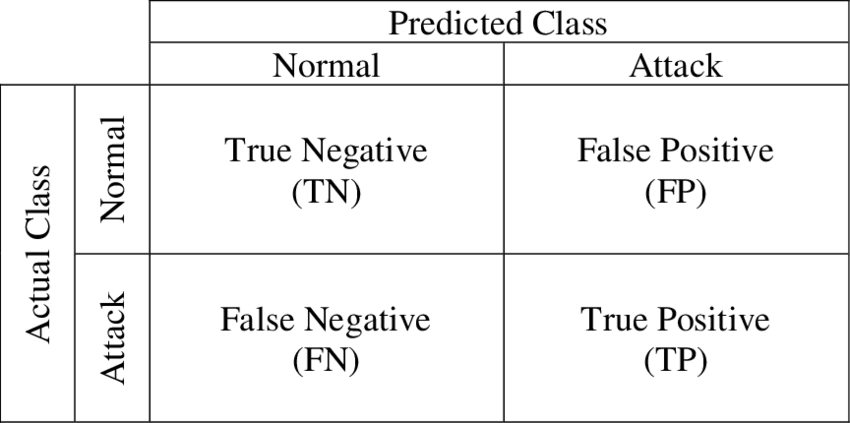

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
print(confusion_matrix(y_test, predict))

#### Precision Score

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

In [0]:
from sklearn.metrics import precision_score

In [0]:
print(precision_score(y_test,predict))

#### Recall score

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

In [0]:
from sklearn.metrics import recall_score

In [0]:
print(recall_score(y_test,predict))

#### f1_score

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
                F1 = 2 \* (precision \* recall) / (precision + recall)

In [0]:
from sklearn.metrics import f1_score

In [0]:
print(f1_score(y_test,predict))

To get all the above metrics at one go, use the following function:

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(y_test,predict))

##6.2 Evaluating BigQuery model

In [0]:
# Display details about the training of the model
%%bigquery
SELECT *
FROM
  ML.TRAINING_INFO ( MODEL `titanic_ml.ML_model` )

In [0]:
# Display the confusion matrix of the model
%%bigquery
SELECT *
FROM
  ML.CONFUSION_MATRIX ( MODEL `titanic_ml.ML_model` )

In [0]:
# Display the model performance during the training process
%%bigquery
SELECT *
FROM
  ML.EVALUATE ( MODEL `titanic_ml.ML_model` )

In [0]:
# Display the weights and coefficient of the model
%%bigquery
SELECT *
FROM
  ML.WEIGHTS ( MODEL `titanic_ml.ML_model` )

In [0]:
# Display the ROC of the model
%%bigquery roc_details
SELECT *
FROM
  ML.ROC_CURVE ( MODEL `titanic_ml.ML_model` )

In [0]:
# plt is from matplotlib imported in step #1
plt.plot(roc_details.false_positive_rate, roc_details.recall)

# Step - 7 : Predict on New Cases

##7.1 Prediction on test data from kaggle

create an account on www.kaggle.com

In [0]:
prod_data=pd.read_csv('production.csv')

In [0]:
prod_data.info()

In [0]:
prod_data.head()


In [0]:
ms.matrix(prod_data)

### Data Cleaning

There are inconsistencies in test data.We can use the same graph functions that are used to visualize the train data for test data as well.We use the same data cleaning techniques like removing the cabin column and applying impute_age function on age column on test data.  
But we cannot remove any rows because kaggle wants same number of rows in submission csv also. So we fill the missing values in fare with mean.

In [0]:
prod_data['Age'].fillna(28, inplace=True)

In [0]:
ms.matrix(prod_data)

In [0]:
prod_data.drop('Cabin', axis = 1, inplace= True)

In [0]:
ms.matrix(prod_data)

In [0]:
prod_data.fillna(prod_data['Fare'].mean(),inplace=True)

In [0]:
prod_data.info()

In [0]:
ms.matrix(prod_data)

In [0]:
sex = pd.get_dummies(prod_data['Sex'], drop_first=True)
embark = pd.get_dummies(prod_data['Embarked'], drop_first=True)

prod_data.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

prod_data = pd.concat([prod_data,sex,embark],axis=1)

In [0]:
# prod_data.drop(['female','C'], axis=1, inplace=True)

In [0]:
prod_data.head()

In [0]:
predict1=logmodel.predict(prod_data)

In [0]:
predict1

In [0]:
df1=pd.DataFrame(predict1,columns=['Survived'])

In [0]:
df2=pd.DataFrame(prod_data['PassengerId'],columns=['PassengerId'])

In [0]:
df2.head()

In [0]:
result = pd.concat([df2,df1],axis=1)
result.head()

In [0]:
result.to_csv('result.csv',index=False)

In [0]:
# Uncomment if you want to download the file to your locak computer
# from google.colab import files
# files.download('bq_result.csv') 

Submit the file to https://www.kaggle.com/c/titanic

##7.2 Prediction on test data in BigQuery

Documentation on BigQuery ML.PREDICT: https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict

Perform feature engineering on test/production data and run it through the ML Predictor.

In [0]:
%%bigquery --params $tbls_param
CREATE OR REPLACE TABLE `titanic_ml.bq_titanic_predict`
AS SELECT
  PassengerId,
  predicted_label AS Survived
FROM
  ML.PREDICT( MODEL `titanic_ml.ML_model`,
    (
      SELECT PassengerId, Pclass,
        IFNULL(Age, @avg_age) As Age,
        SibSp, Parch, Fare,
        count(case when Sex = 'male' then 1 end) as male,
        count(case when Embarked = 'Q' then 1 end) as Q,
        count(case when Embarked = 'S' then 1 end) as S
      FROM `titanic_ml.titanic_test_raw`
      GROUP BY Age, PassengerId,Pclass,SibSp,Parch,Fare
    )
  )

Download the results to a dataframe, sort the results by PassengerId and display the results.

In [0]:
%%bigquery test_prediction
SELECT *
FROM `titanic_ml.bq_titanic_predict`

In [0]:
test_prediction.sort_values('PassengerId', inplace=True)
test_prediction.head(30)

In [0]:
test_prediction.to_csv('bq_result.csv',index=False)

In [0]:
# Uncomment if you want to download the file to your local computer
# from google.colab import files
# files.download('bq_result.csv') 

In [0]:
# Stop Execution to check the code
%%writefile

# Delete Project

In [0]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

credentials = GoogleCredentials.get_application_default()

service = discovery.build('cloudresourcemanager', 'v1', credentials=credentials)


request = service.projects().delete(projectId=project_id)
request.execute()